### 데이터 살펴보기

메서드 불러오기

In [1]:
import pandas as pd
import numpy as np

# 시각화
import seaborn as sns

# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore') 

# 버전 확인
print('Pandas : %s'%(pd.__version__))
print('seaborn : %s'%(sns.__version__))
!python --version

Pandas : 1.2.1
seaborn : 0.11.1
Python 3.8.13


In [2]:
# 데이터 불러오기
user = pd.read_csv('../data/user_spec.csv')
loan = pd.read_csv('../data/loan_result.csv')
log = pd.read_csv('../data/log_data.csv')

### 1. 유저 스펙 테이블

- na값에 대한 확인

In [3]:
user.isna().sum()

application_id                               0
user_id                                      0
birth_year                               12961
gender                                   12961
insert_time                                  0
credit_score                            105115
yearly_income                               90
income_type                                 85
company_enter_month                     171760
employment_type                             85
houseown_type                               85
desired_amount                              85
purpose                                     85
personal_rehabilitation_yn              587461
personal_rehabilitation_complete_yn    1203354
existing_loan_cnt                       198556
existing_loan_amt                       313774
dtype: int64

    - birth_year와 gender 결측값 채워줌

In [4]:
###### birth_year #####
user['birth_year'] = user['birth_year'].fillna('없음')

# 전처리할 데이터 재생성
bir = user.groupby('user_id')['birth_year'].apply(set).reset_index()
bir['len'] = bir['birth_year'].apply(lambda x:len(x))

# 0을 지워주는 함수 생성
def remove0(x):
    if len(x) == 2: 
        x_ = x.remove('없음')
        return x_
    else: return x

# 적용
bir['birth_year'].apply(remove0)
bir['year'] = bir['birth_year'].apply(lambda x:list(x)[0])

# 딕셔너리로 변환하여 저장
birth_year = {x:y for x,y in zip(bir['user_id'], bir['year'])}

# 적용하여 변환
user['birth_year'] = user['user_id'].apply(lambda x:birth_year[x])

In [5]:
###### gender #####
user['gender'] = user['gender'].fillna('없음')

# 전처리할 데이터 재생성
g = user.groupby('user_id')['gender'].apply(set).reset_index()
g['len'] = g['gender'].apply(lambda x:len(x))

# 0을 지워주는 함수 생성
def remove2(x):
    if len(x) == 2: 
        x_ = x.remove('없음')
        return x_
    else: return x

# 적용
g['gender'].apply(remove2)
g['g'] = g['gender'].apply(lambda x:list(x)[0])

# 딕셔너리로 변환하여 저장
gender = {x:y for x,y in zip(g['user_id'], g['g'])}

# 적용하여 변환
user['gender'] = user['user_id'].apply(lambda x:gender[x])

    - personal_rehabilitation_complete_yn
        -> 문의 필요

In [6]:
# na값을 확인 하였을 때, personal_rehabilitation_complete_yn의 값이 높은데, 이는 개인 회생자가 아닌 사람도 포함 돼있기 때문으로 보임
## na중 personal_rehabilitation_yn의 값이 0인 값은 개인회생자 아님 등으로 채워야할 듯함
user[user['personal_rehabilitation_complete_yn'].isna()]['personal_rehabilitation_yn'].unique()

array([ 0., nan])

In [7]:
user.query('personal_rehabilitation_yn == 0')['personal_rehabilitation_complete_yn'].value_counts()

0.0    178149
1.0         4
Name: personal_rehabilitation_complete_yn, dtype: int64

In [8]:
user.query('personal_rehabilitation_yn == 1')['personal_rehabilitation_complete_yn'].value_counts()

0.0    11361
1.0     1348
Name: personal_rehabilitation_complete_yn, dtype: int64

분포를 확인해보았을 때, personal_rehabilitation_complete_yn에 기록이 있으면 personal_rehabilitation_yn가 1인 것으로 생각하여 채워야될듯함

In [9]:
# 기록이 있으면 개인회생자, 없으면 아닌 사람으로 기록
user['personal_rehabilitation_yn'] = user['personal_rehabilitation_complete_yn'].apply(lambda x:1 if x in [0,1] else 0)
# 나머지 기록이 na인 값은 전부 개인회생자가 아닌 것으로 확인함 -> 2( 개인회생자아님 )로 채워줌
user['personal_rehabilitation_complete_yn'] = user['personal_rehabilitation_complete_yn'].fillna(2)

    - company_enter_month

In [10]:
# company_enter_month에 대한 na값은 입사 년월을 입력하지 못하는 사람들이 대부분임
## 입사년월이 없는 사람 (ex)개인 사업, 소득이 회사가 아닌 경우 등 )
## 다른 옵션으로 채워야할듯함
user[user['company_enter_month'].isna()]['income_type'].value_counts()

OTHERINCOME        171665
EARNEDINCOME            7
PRIVATEBUSINESS         3
Name: income_type, dtype: int64

In [11]:
# OTHERINCOME을 제외하면 na값이 적기 때문에 입사년도 없음으로 채워줌
user['company_enter_month'] = user['company_enter_month'].fillna('입사년도 없음')

    - credit_score

In [12]:
# 68018명의 사람들의 신용정보 확인 불가능
user[['user_id', 'credit_score']].drop_duplicates(subset='user_id').isna().sum()

user_id             0
credit_score    68018
dtype: int64

In [13]:
# 신용 점수가 있는 고객들은 해당 고객이 가진 신용 점수의 평균으로 채워줌
user['credit_score'] = user['credit_score'].fillna(user.groupby('user_id')['credit_score'].transform('mean'))

In [14]:
# 채운 후에도 na값인 경우는 신용 점수를 확인한 적이 한번도 없는 고객임
user[user['credit_score'].isna()].groupby('user_id')['credit_score'].count().unique()

array([0], dtype=int64)

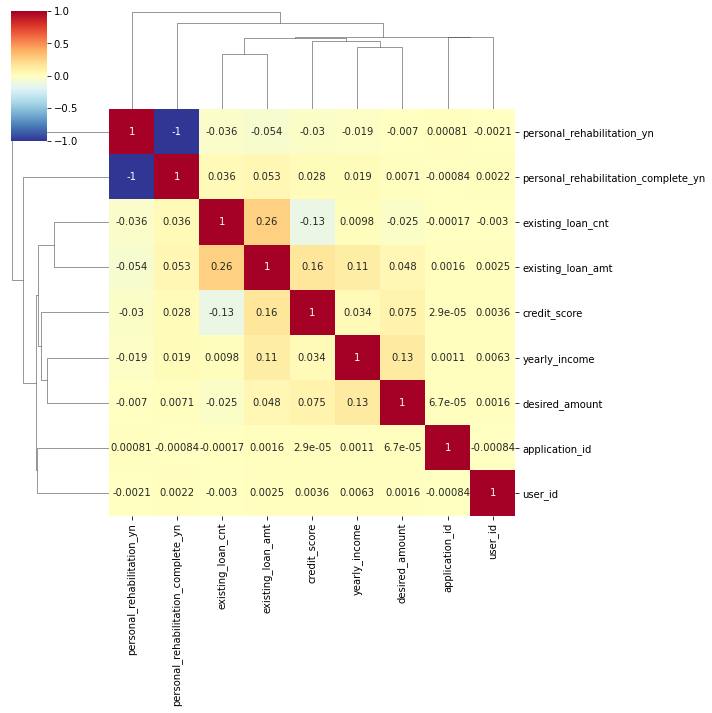

In [15]:
# 컬럼들과 credit score간의 상관관계를 시각화해 보았으나 의미 X 그냥 평균으로 채움

sns.clustermap(user.corr(), 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [16]:
# 평균으로 채워줌
user['credit_score'] = user['credit_score'].fillna(user['credit_score'].mean())

    - existing_loan_cnt

In [17]:
# existing_loan_cnt의 값이 0인 행이 없는 것으로 보아 na인 경우는 기대출수가 0이지 않을까 하는 추축
user[user['existing_loan_cnt'] == 0]

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt


In [18]:
# existing_loan_cnt가 na인 값의 amt는 모두 na인 모습을 보임
user[user['existing_loan_cnt'].isna()][['existing_loan_cnt','existing_loan_amt']].isna().sum()

existing_loan_cnt    198556
existing_loan_amt    198556
dtype: int64

In [19]:
# existing_loan_cnt와 existing_loan_amt의 수가 na인 값은 0으로 채워줌
user['existing_loan_cnt'] = user['existing_loan_cnt'].fillna(0)
user['existing_loan_amt'] = user['existing_loan_amt'].fillna(0)

    - yearly_income, income_type

In [20]:
# 연소득이 na인 값의 소득 경로를 확인해 본 결과 na인 값이 85개, 다른 수익 4, 프리랜서가 1인 모습을 보임
## -> 즉, na인 것은 연소득이 없다는 뜻임
user[user['yearly_income'].isna()]['income_type'].value_counts()

OTHERINCOME    4
FREELANCER     1
Name: income_type, dtype: int64

In [21]:
# 0으로 채워줌
user['yearly_income'] = user['yearly_income'].fillna(0)
user['income_type'] = user['income_type'].fillna('직장없음')

    - employment_type

In [22]:
# employment_type의 경우 company_enter_month의 값이 입사년도없음임
user[user['employment_type'].isna()]['company_enter_month'].unique()

array(['입사년도 없음'], dtype=object)

In [23]:
# 입사년도가 없다는 것은 기타이기 때문에 기타로 채워줌
user['employment_type'] = user['employment_type'].fillna('기타')

    - houseown_type

In [24]:
# houseown_type이 na인 값은 그냥 귀찮아서 안찍은듯함
user['houseown_type'].unique()

array(['자가', '기타가족소유', '전월세', '배우자', nan], dtype=object)

In [25]:
## -> 정보없음으로 채워줌
user['houseown_type'] = user['houseown_type'].fillna('정보없음')

    - desired_amount

In [26]:
# 이 경우도 선택을 그냥 하지 않은 경우이기 때문에 최빈값으로 채워줌
## 단순한 궁금증으로 인하여 선택을 한 경우라고 판단 -> 가장 많이 원하는 금액으로 채움
user['desired_amount'] = user['desired_amount'].fillna(user['desired_amount'].mode()[0])

    - purpose

In [27]:
# 목적 또한 위와 같음
## 최빈값으로 채움
user['purpose'] = user['purpose'].fillna(user['purpose'].mode()[0])

In [28]:
user.isna().sum()

application_id                         0
user_id                                0
birth_year                             0
gender                                 0
insert_time                            0
credit_score                           0
yearly_income                          0
income_type                            0
company_enter_month                    0
employment_type                        0
houseown_type                          0
desired_amount                         0
purpose                                0
personal_rehabilitation_yn             0
personal_rehabilitation_complete_yn    0
existing_loan_cnt                      0
existing_loan_amt                      0
dtype: int64

### 2. 대출 상품 결과 테이블

- 중복값을 갖는 행 처리

In [29]:
# 데이터가 중복인 경우가 25개 존재하여 삭제해줌
len(loan[loan.duplicated()])

26

In [30]:
# 중복 제거하여 데이터 선언
loan = loan.drop_duplicates()

- 결측값 처리

In [31]:
loan.isna().sum()

application_id                 0
loanapply_insert_time          0
bank_id                        0
product_id                     0
loan_limit                  7495
loan_rate                   7495
is_applied               3257223
dtype: int64

In [32]:
# loan_limit과 loan_rate는 동일한 행에서 na값을 가짐을 확인
loan[loan['loan_limit'].isna()]['loan_rate'].unique()

array([nan])

In [33]:
# 타겟값에 대한 확인을 위해 월별로 확인
loan['month'] = loan['loanapply_insert_time'].apply(lambda x:x[5:7])

# train data의 경우 loan_limit과 loan_rate가 na인 경우 타겟값이 모두 1임을 알 수 있음
loan[(loan['loan_limit'].isna()) & (loan['month'] != '06')]['is_applied'].value_counts()

1.0    5738
Name: is_applied, dtype: int64

In [34]:
# 전체 타겟값 대비 1% 정도가 위와 같은 모습을 보임
## -> 비슷한 형태를 띄는 행으로 결측값 대체
loan['is_applied'].value_counts()

0.0    9709673
1.0     560441
Name: is_applied, dtype: int64

    - loan_rate

In [35]:
# 일부 행만 null인 경우 결측치를 product별 평균
product_list = loan[loan['loan_limit'].isna()]['product_id'].unique()

for i in product_list:
    len_rate = loan[loan['product_id'] == i]['loan_rate'].unique()
    
    if len(len_rate) > 1:
        loan.loc[(loan['product_id'] == i) & (loan['loan_rate'].isna()), 'loan_rate'] = round(np.nanmean(len_rate), 1)

        
# 모두 null인 경우 결측치를 application별 평균
loan['loan_rate'] = loan['loan_rate'].fillna(loan.groupby('application_id')['loan_rate'].transform('mean'))

# application이 하나인 데이터 최빈값 대체
loan['loan_rate'] = loan['loan_rate'].fillna(loan['loan_rate'].mode()[0])

    - loan_limit

In [36]:
# loan_limit 결측치를 application별로 평균
loan['loan_limit'] = loan['loan_limit'].fillna(loan.groupby('application_id')['loan_limit'].transform('mean'))

# application이 하나인 결측치 최빈값으로
loan['loan_limit'] = loan['loan_limit'].fillna(loan['loan_limit'].mode()[0])

In [37]:
loan.isna().sum()

application_id                 0
loanapply_insert_time          0
bank_id                        0
product_id                     0
loan_limit                     0
loan_rate                      0
is_applied               3257223
month                          0
dtype: int64

## 데이터 병합 및 저장

In [38]:
# train에 신청서 id가 있으나 user에 없는 데이터 지우고 진행
## default가 inner이기 때문에 자연스럽게 지워짐
data = pd.merge(loan, user, on='application_id')

In [1]:
user.to_csv('../data/user_fillna.csv', index = False)

NameError: name 'user' is not defined

In [ ]:
loan.to_csv('../data/loan_fillna.csv', index = False)

In [40]:
data.to_csv('../data/data.csv', index = False)

## END